Optimized Parameters:
A1: 0.0023276983288815284
g1: 0.9999992345567842
A2: 0.00025676196653721814
g2: 0.9999976044234002
kb1: 0.030060046846426686
b1: 0.18999836522389624
kb2: 1.1200000004581556
b2: 0.11719999925947854


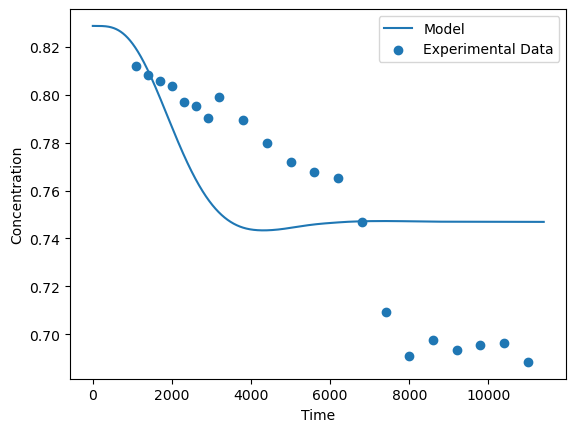

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Given data
Time = np.array([1100,1400,1700,2000,2300,2600,2900,3200,3800,4400,5000,5600,6200,6800,7400,8000,8600,9200,9800,10400,11000])
Concentration = np.array([0.8119074939,0.8080550257,0.8056126769,0.8037800776,0.7971050414,0.7952981708,0.7901365596,0.7988397723,0.7892703199,0.7799543858,0.7717273711,0.7678655099,0.7654176994,0.7467064548,0.7093724843,0.6910878323,0.6976557697,0.6933652931,0.6956656918,0.6965078415,0.6884784269])
def generateODE2(t, m, A1, g1, A2, g2, kb1, b1,kb2,b2, V):
    # Unpack the variables from the y vector
    m00, m10, m01, m11, c = m

    Ci = 0.8287                     # gm/(100 gm of mixed solvent)
    Ce = 0.5779                      # gm/(100 gm of mixed solvent)
    
    
    #calulate neccessary quantity
    
    f = 2.5 * 10**-7                     # m3/sec 
    ρc = 1400 * 10**3                    # gm/m3
    h = 1 * 10**(-5)                     # m
    Vc = h * m11
    ρl = 785 * 10**3                     # gm/m3
    V = 0.0002
    tau = V / f
    
    delta_c = max(c - Ce, 0)
    s = delta_c / Ce
    
    Gl = A1 * (s)**g1
    Gw = A2 * (s)**g2
    B = kb1 * (s)**b1  + kb2*Vc*s**b2

    dm00 = B - (m00 / tau)
    dm10 = (Gl * m00) - (m10 / tau)
    dm01 = (Gw * m00) - (m01 / tau)
    dm11 = (Gl * m10) + (Gw * m01) - (m11 / tau)
    dc = (Ci / tau) - (c / tau) - (ρc / ρl) * Vc

    return [dm00, dm10, dm01, dm11, dc]

def objective(params):
    A1, g1, A2, g2, kb1, b1, kb2, b2  = params
    V = 0.0002  # Volume, adjust as needed
    t_span = (0, 11400)  # Adjust this to match the maximum time in your data
    num_points = 11400
    initialConditions = [0, 0, 0, 0, 0.8287]
    sol = solve_ivp(
        lambda t, m: generateODE2(t, m, A1, g1, A2, g2, kb1, b1,kb2,b2, V),
        t_span,
        initialConditions,
        t_eval=np.linspace(t_span[0], t_span[1], num_points)
    )
    
    # Ensure that the interpolation is within the range of the solution
    interp_t = np.clip(Time, sol.t[0], sol.t[-1])
    
    # Interpolate the solution at the time points specified in Time
    interp_solution = interp1d(sol.t, sol.y[4], bounds_error=False, fill_value="extrapolate")
    model_predictions = interp_solution(Time)
    error = np.sum((model_predictions - Concentration)**2)  # Sum of squared differences
    return error

# Initial guess for parameters
initial_guess =  [0.00001313983, 1, 0.00002593650, 1.43, 0.03, 0.19, 1.12,0.1172]

# Bounds for the parameters
bounds = [(0, 0.1),   # A1
          (0, 2),      # g1
          (0, 0.01),     # A2
          (0, 1),        # g2
          (0, 2),        # kb1
          (0, 2),          #b1
         (0, 2),         #kb2
         (0,2)]         # b2

# Minimize the objective function with bounds
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)
# Extract the optimized parameters
A1_opt, g1_opt, A2_opt, g2_opt, kb1_opt, b1_opt, kb2_opt, b2_opt = result.x
print("Optimized Parameters:")
print("A1:", A1_opt)
print("g1:", g1_opt)
print("A2:", A2_opt)
print("g2:", g2_opt)
print("kb1:", kb1_opt)
print("b1:", b1_opt)
print("kb2:", kb2_opt)
print("b2:", b2_opt)

# Plot the optimized model against the data
t_span = (0, 11400)
num_points = 11400
initialConditions = [0, 0, 0, 0, 0.8287]
sol = solve_ivp(
    lambda t, m: generateODE2(t, m, A1_opt, g1_opt, A2_opt, g2_opt, kb1_opt, b1_opt, kb2_opt, b2_opt, 0.0002),
    t_span,
    initialConditions,
    t_eval=np.linspace(t_span[0], t_span[1], num_points)
)
plt.plot(sol.t, sol.y[4], label='Model')
plt.scatter(Time, Concentration, label='Experimental Data')
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()